# Win probability added

- El 14-10-2022, Pablo (@jeffckley) me preguntó que si existía una estadística que calculará el epa por triunfo, esa estadística como tal no exite, pero si tenemos a Win Probability Added, que mide la diferencia de probabilidades de ganar antes y después de una jugada.

In [1]:
# Librerías a utilizar
import pandas as pd  
import numpy as np


# Para evitar molestas warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Código para las últimas 15 temporadas
YEARS = range(2008,2023) #Rango 2008-23


#la función for nos arroja el rango de años que queremos utilizar 
#usaremos la función append para unir la información y ordenarla por año
data = pd.DataFrame()

for i in YEARS:  
    i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(i) + '.csv.gz',
                   compression= 'gzip', low_memory= False)
    data = data.append(i_data, sort=True)
    
    

data.head(1)

,aborted_play,air_epa,air_wpa,air_yards,assist_tackle,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,...,xyac_median_yardage,xyac_success,yac_epa,yac_wpa,yardline_100,yards_after_catch,yards_gained,ydsnet,ydstogo,yrdln
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,ARI 30


In [4]:
data.shape

(690661, 372)

# Reorganización de los datos

- Eliminamos jugadas sin epa ni wpa
- Ajustamos los scrambles como pass_play

In [6]:
# Eliminamos jugadas sin epa ni wpa

df = data[(data['epa'].isna()==False)&
          (data['wpa'].isna()==False)]

# Si el qb retrocede a lanzar, la jugada se contabilizará como pase

df.loc[df['pass']==1, 'play_type'] = 'pass'

# Si es un acarreo designado, la jugada se contabilizará como acarreo

df.loc[df['rush']==1, 'play_type'] = 'run'

wp_df = df[df['play_type']=='pass'].groupby(['passer',
                                             'passer_id']).agg(dropbacks = ('pass', 'sum'),
                                                               epa = ('epa', 'mean'),
                                                               wpa = ('wpa', 'mean')).sort_values(by='wpa', ascending=False)

wp_df = wp_df[wp_df['dropbacks']>=500].reset_index()

wp_df.index = wp_df.index + 1

print("QBs, desde 2010, con al menos 500 dropbacks, ordenados por Win Probability Added:")

wp_df.round(3).head(20)



QBs, desde 2010, con al menos 500 dropbacks, ordenados por Win Probability Added:


,passer,passer_id,dropbacks,epa,wpa
1,P.Mahomes,00-0033873,3513,0.283,0.008
2,J.Garoppolo,00-0031345,1919,0.183,0.006
3,J.Herbert,00-0036355,1693,0.166,0.006
4,A.Rodgers,00-0023459,9556,0.222,0.005
5,D.Watson,00-0033537,2390,0.165,0.005
6,J.Burrow,00-0036442,1495,0.120,0.005
7,P.Manning,00-0010346,4861,0.214,0.005
8,D.Brees,00-0020531,8891,0.195,0.005
9,T.Brady,00-0019596,10188,0.209,0.005
10,T.Tagovailoa,00-0036212,930,0.083,0.004


In [68]:
# Dataframe nuevo

# Juegos de local

home = df[(df['posteam_type']== 'home')&
          (df['play_type'].isin(['pass']))&
          (df['two_point_attempt']==0)]

# Eliminamos las capturs de los intentos de pase

home.loc[home['sack']==1, 'pass_attempt'] = 0

# Si pass y dropback son iguales, quiere decir que el castigo se rechazo o se adiciono yardaje despues de la jugada

home.loc[home['pass'] == home['qb_dropback'], 'penalty'] = 0

# Si hay castigo en la jugada, no hay scramble

home.loc[home['penalty'] == 1, 'qb_scramble'] = 0

# Record


home['win_pct'] = np.where(home['home_score']>home['away_score'],1,np.where(home['away_score']>home['home_score'],0,0.5))

# agrupamos por fecha de juego y temporada

home_ag = home.groupby(['passer',
                     'passer_id',
                     'game_date', 
                     'season',
                     'season_type',
                     'posteam',
                     'defteam']).agg(points_for = ('home_score', 'mean'),
                                     points_ag = ('away_score', 'mean'),
                                     plays = ('pass', 'sum'),
                                     penalty = ('penalty','sum'),
                                     dropback = ('qb_dropback', 'sum'),
                                     scrambles = ('qb_scramble', 'sum'),
                                     sack = ('sack', 'sum'),
                                     pass_att = ('pass_attempt', 'sum'),
                                     comp_pass = ('complete_pass', 'sum'),
                                     pass_yards = ('passing_yards', 'sum'),
                                     pass_td = ('pass_touchdown', 'sum'),
                                     pass_int = ('interception', 'sum'),
                                     net_pass_yards = ('yards_gained', 'sum'),
                                     rushing_yards = ('rushing_yards', 'sum'),
                                     rush_td = ('rush_touchdown', 'sum'),
                                     qb_epa = ('qb_epa', 'sum'),
                                     qb_success = ('success', 'sum'),
                                     epa_db = ('qb_epa', 'mean'),
                                     success_rate = ('success', 'sum'),
                                     win_pct = ('win_pct', 'mean')).sort_values(by='game_date').reset_index()

home_ag['net_pass_yards'] = home_ag['net_pass_yards'] - home_ag['rushing_yards']

home_ag.round(2)

,passer,passer_id,game_date,season,season_type,posteam,defteam,points_for,points_ag,plays,...,pass_td,pass_int,net_pass_yards,rushing_yards,rush_td,qb_epa,qb_success,epa_db,success_rate,win_pct
0,E.Manning,00-0022803,2008-09-04,2008,REG,NYG,WAS,16.0,7.0,39,...,0.0,1.0,200.0,0.0,0.0,2.35,20.0,0.06,20.0,1.0
1,K.Kolb,00-0025423,2008-09-07,2008,REG,PHI,LA,38.0,3.0,7,...,0.0,0.0,53.0,0.0,0.0,5.11,6.0,0.73,6.0,1.0
2,P.Rivers,00-0022942,2008-09-07,2008,REG,LAC,CAR,24.0,26.0,29,...,3.0,0.0,211.0,0.0,0.0,9.07,11.0,0.31,11.0,0.0
3,J.O'Sullivan,00-0021296,2008-09-07,2008,REG,SF,ARI,13.0,23.0,25,...,0.0,1.0,183.0,2.0,0.0,-10.64,10.0,-0.43,10.0,0.0
4,B.Moorman,00-0011626,2008-09-07,2008,REG,BUF,SEA,34.0,10.0,1,...,1.0,0.0,19.0,0.0,0.0,4.39,1.0,4.39,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4660,M.Stafford,00-0026498,2022-10-09,2022,REG,LA,DAL,10.0,22.0,48,...,1.0,1.0,273.0,0.0,0.0,-15.85,18.0,-0.33,18.0,0.0
4661,T.Lawrence,00-0036971,2022-10-09,2022,REG,JAX,HOU,6.0,13.0,50,...,0.0,2.0,286.0,26.0,0.0,-6.10,20.0,-0.12,20.0,0.0
4662,Z.Wilson,00-0037013,2022-10-09,2022,REG,NYJ,MIA,40.0,17.0,26,...,0.0,0.0,187.0,5.0,1.0,5.68,14.0,0.22,14.0,1.0
4663,P.Mahomes,00-0033873,2022-10-10,2022,REG,KC,LV,30.0,29.0,50,...,4.0,0.0,265.0,20.0,0.0,16.36,28.0,0.33,28.0,1.0


In [70]:
# QB rankeados por juegos de local

board = home_ag.groupby(['passer', 
                         'passer_id',
                         'posteam']).agg({'dropback':'sum',
                                             'qb_epa':'sum',
                                             'qb_success':'sum',
                                          'win_pct': 'mean'})

# Eficiencia por dropback

board['epa_db'] = board['qb_epa']/board['dropback']

# Porcentaje de jugadas de epa positivo

board['success_rate'] = board['qb_success']/board['dropback']

# Formateamos el indice

# Reorganizamos el tablero

board = board[board['dropback']>=1000].sort_values(by='epa_db', ascending=False).reset_index().round(3)

# Valores inician en 1 y van de 1 en 1

board.index = board.index + 1


# Tablero top-10

print("De 2008 hasta hoy, Patrick Mahomes es el rey del epa como local")

board.head(20)

De 2008 hasta hoy, Patrick Mahomes es el rey del epa como local


,passer,passer_id,posteam,dropback,qb_epa,qb_success,win_pct,epa_db,success_rate
1,P.Mahomes,00-0033873,KC,1723.0,516.441,968.0,0.810,0.300,0.562
2,A.Rodgers,00-0023459,GB,4353.0,1165.059,2358.0,0.796,0.268,0.542
3,D.Brees,00-0020531,NO,4312.0,1105.312,2401.0,0.697,0.256,0.557
4,T.Brady,00-0019596,NE,4091.0,997.582,2222.0,0.846,0.244,0.543
5,P.Manning,00-0010346,DEN,1378.0,324.536,759.0,0.838,0.236,0.551
6,P.Manning,00-0010346,IND,1090.0,237.384,603.0,0.750,0.218,0.553
7,B.Roethlisberger,00-0022924,PIT,4029.0,761.560,2102.0,0.731,0.189,0.522
8,R.Wilson,00-0029263,SEA,2922.0,541.816,1484.0,0.729,0.185,0.508
9,C.Palmer,00-0021429,ARI,1259.0,232.022,663.0,0.734,0.184,0.527
10,P.Rivers,00-0022942,LAC,3624.0,667.258,1912.0,0.551,0.184,0.528


In [74]:
# Juegos de local

away = df[(df['posteam_type']== 'away')&
          (df['play_type'].isin(['pass']))&
          (df['two_point_attempt']==0)]

# Eliminamos las capturs de los intentos de pase

away.loc[away['sack']==1, 'pass_attempt'] = 0

# Si pass y dropback son iguales, quiere decir que el castigo se rechazo o se adiciono yardaje despues de la jugada

away.loc[away['pass'] == away['qb_dropback'], 'penalty'] = 0

# Si hay castigo en la jugada, no hay scramble

away.loc[away['penalty'] == 1, 'qb_scramble'] = 0

# Record

away['win_pct'] = np.where(away['away_score']>away['home_score'],1,np.where(away['away_score']<away['home_score'],0,0.5))

# agrupamos por fecha de juego y temporada

away_ag = away.groupby(['passer',
                     'passer_id',
                     'game_date', 
                     'season',
                     'season_type',
                     'posteam',
                     'defteam']).agg(points_for = ('away_score', 'mean'),
                                     points_ag = ('home_score', 'mean'),
                                     plays = ('pass', 'sum'),
                                     penalty = ('penalty','sum'),
                                     dropback = ('qb_dropback', 'sum'),
                                     scrambles = ('qb_scramble', 'sum'),
                                     sack = ('sack', 'sum'),
                                     pass_att = ('pass_attempt', 'sum'),
                                     comp_pass = ('complete_pass', 'sum'),
                                     pass_yards = ('passing_yards', 'sum'),
                                     pass_td = ('pass_touchdown', 'sum'),
                                     pass_int = ('interception', 'sum'),
                                     net_pass_yards = ('yards_gained', 'sum'),
                                     rushing_yards = ('rushing_yards', 'sum'),
                                     rush_td = ('rush_touchdown', 'sum'),
                                     qb_epa = ('qb_epa', 'sum'),
                                     qb_success = ('success', 'sum'),
                                     epa_db = ('qb_epa', 'mean'),
                                     success_rate = ('success', 'sum'),
                                     win_pct = ('win_pct', 'mean')).sort_values(by='game_date').reset_index()

away_ag['net_pass_yards'] = away_ag['net_pass_yards'] - away_ag['rushing_yards']

away_ag.round(2)

,passer,passer_id,game_date,season,season_type,posteam,defteam,points_for,points_ag,plays,...,pass_td,pass_int,net_pass_yards,rushing_yards,rush_td,qb_epa,qb_success,epa_db,success_rate,win_pct
0,J.Campbell,00-0023460,2008-09-04,2008,REG,WAS,NYG,7.0,16.0,29,...,1.0,0.0,125.0,0.0,0.0,-7.09,9.0,-0.24,9.0,0.0
1,C.Palmer,00-0021429,2008-09-07,2008,REG,CIN,BAL,10.0,17.0,30,...,0.0,1.0,89.0,13.0,0.0,-13.29,9.0,-0.44,9.0,0.0
2,M.Bulger,00-0019599,2008-09-07,2008,REG,LA,PHI,3.0,38.0,31,...,0.0,0.0,130.0,0.0,0.0,-5.32,9.0,-0.17,9.0,0.0
3,T.Romo,00-0021678,2008-09-07,2008,REG,DAL,CLE,28.0,10.0,36,...,1.0,1.0,320.0,0.0,0.0,18.13,23.0,0.50,23.0,1.0
4,J.Kitna,00-0009311,2008-09-07,2008,REG,DET,ATL,21.0,34.0,41,...,2.0,1.0,246.0,8.0,0.0,9.39,23.0,0.23,23.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621,J.Goff,00-0033106,2022-10-09,2022,REG,DET,NE,0.0,29.0,41,...,0.0,1.0,211.0,8.0,0.0,-20.44,15.0,-0.50,15.0,0.0
4622,D.Mills,00-0036898,2022-10-09,2022,REG,HOU,JAX,13.0,6.0,26,...,0.0,0.0,132.0,0.0,0.0,-1.83,11.0,-0.07,11.0,1.0
4623,S.Thompson,00-0037327,2022-10-09,2022,REG,MIA,NYJ,17.0,40.0,39,...,0.0,1.0,158.0,0.0,0.0,-9.53,18.0,-0.24,18.0,0.0
4624,D.Carr,00-0031280,2022-10-10,2022,REG,LV,KC,29.0,30.0,37,...,2.0,0.0,223.0,3.0,0.0,12.45,15.0,0.34,15.0,0.0


In [76]:
# QB rankeados por juegos de visitante

board = away_ag.groupby(['passer', 
                         'passer_id',
                         'posteam']).agg({'dropback':'sum',
                                          'win_pct': 'mean',
                                             'qb_epa':'sum',
                                             'qb_success':'sum'})

# Eficiencia por dropback

board['epa_db'] = board['qb_epa']/board['dropback']

# Porcentaje de jugadas de epa positivo

board['success_rate'] = board['qb_success']/board['dropback']

# Formateamos el indice

# Reorganizamos el tablero

board = board[board['dropback']>=1000].sort_values(by='epa_db', ascending=False).reset_index().round(3)

# Valores inician en 1 y van de 1 en 1

board.index = board.index + 1


# Tablero top-10

print("De 2008 hasta hoy, Patrick Mahomes es el rey del epa como visitante")

board.head(20)

De 2008 hasta hoy, Patrick Mahomes es el rey del epa como visitante


,passer,passer_id,posteam,dropback,win_pct,qb_epa,qb_success,epa_db,success_rate
1,P.Mahomes,00-0033873,KC,1546.0,0.757,536.775,892.0,0.347,0.577
2,A.Rodgers,00-0023459,GB,4600.0,0.530,1082.154,2429.0,0.235,0.528
3,T.Brady,00-0019596,NE,3686.0,0.656,847.952,1940.0,0.230,0.526
4,P.Rivers,00-0022942,LAC,3765.0,0.465,831.069,1980.0,0.221,0.526
5,D.Watson,00-0033537,HOU,1091.0,0.464,233.779,586.0,0.214,0.537
6,J.Allen,00-0034857,BUF,1472.0,0.556,299.576,783.0,0.204,0.532
7,P.Manning,00-0010346,DEN,1187.0,0.690,240.804,626.0,0.203,0.527
8,J.Winston,00-0031503,TB,1338.0,0.361,263.589,717.0,0.197,0.536
9,D.Brees,00-0020531,NO,4162.0,0.559,805.917,2197.0,0.194,0.528
10,T.Romo,00-0021678,DAL,1935.0,0.537,335.637,986.0,0.173,0.510


In [31]:
# Importamos librrías para gráficar 
import matplotlib.pyplot as plt  
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.patches as patch
import seaborn as sns

%matplotlib inline

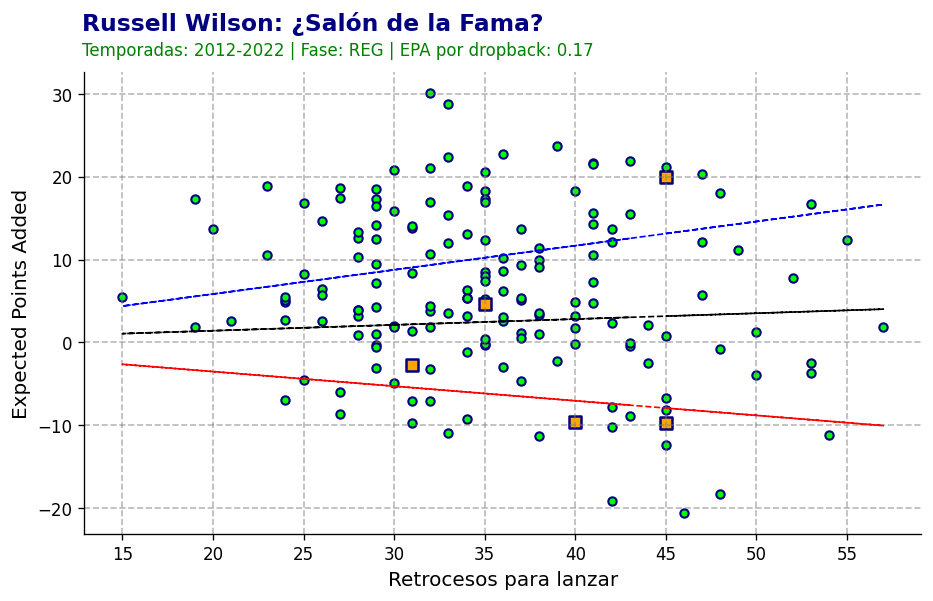

In [167]:
total_qb = pd.concat([home_ag, away_ag]).sort_values(by='game_date').reset_index(drop=True)


#Figura donde se insertara la grafica
fig= plt.figure(figsize= (9,5), dpi= 120)
ax= plt.subplot(111, facecolor= "white")

# Formato del contorno de figura y líneas de división de ejes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(lw = 1, color = "grey", ls='--', alpha=0.55)

q1 = np.percentile(total_qb['epa_db'], 25)

med = np.percentile(total_qb['epa_db'], 50)

q3 = np.percentile(total_qb['epa_db'], 75)

plot = total_qb[(total_qb['passer']=='R.Wilson')&(total_qb['season_type']=='REG')]

x = plot['dropback']

y = plot['qb_epa']

# Diagrama de dispersión

ax.scatter(x,y, marker='o', ec='navy', color='lime', lw=1.25, s=25)

# Línea de media

ax.plot(x, x*med, ls='--', lw=1, color='black')

# Líneas de ls mejores 25% eficiencia de qb

ax.plot(x, x*q3, lw=1, ls='--', color='blue')

# Línea de las peores 25% eficiencia de qb

ax.plot(x, x*q1, lw=1, ls='--', color='red')

# Títulos

ax.text(x.min()*0.85, 
        y.max()*1.25, 
        s='Russell Wilson: ¿Salón de la Fama?', 
        color='navy',
        fontweight='bold',
        fontsize=14)

# Subtítulo

ax.text(x.min()*0.85, 
        y.max()*1.15, 
        s=f"Temporadas: {plot['season'].min()}-{plot['season'].max()} | Fase: {plot['season_type'].iloc[-1]} | EPA por dropback: {(plot['qb_epa'].sum()/plot['dropback'].sum()).round(2)}", 
        color='green', 
        fontsize=10)

# Formato del eje Y

ax.set_ylabel('Expected Points Added', fontsize= 12)

# Formato del eje X

ax.set_xticks(np.arange(15, 60, 5))

ax.set_xlabel('Retrocesos para lanzar', fontsize=12)

# Identificar juegos con otros equipos

ax.scatter(plot[plot['posteam']=='DEN']['dropback'],
           plot[plot['posteam']=='DEN']['qb_epa'],
           marker='s',
           color='orange',
           ec ='navy',
           lw=1.5,
           s=50)